In [1]:
import pandas as pd
import numpy as np 
import seaborn as sn
import matplotlib.pyplot as plt
%matplotlib inline

from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
import re

#Importing our Sklearn Plugins
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn import preprocessing


In [2]:
# import the CLean dataset

df = pd.read_csv('CleanData2.csv')


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17225 entries, 0 to 17224
Data columns (total 13 columns):
Unnamed: 0             17225 non-null int64
title                  17225 non-null object
description            17225 non-null object
telecommuting          17225 non-null int64
has_company_logo       17225 non-null int64
has_questions          17225 non-null int64
employment_type        17225 non-null object
required_experience    17225 non-null object
required_education     17225 non-null object
industry               17225 non-null object
function               17225 non-null object
fraudulent             17225 non-null int64
country_name           17225 non-null object
dtypes: int64(5), object(8)
memory usage: 1.7+ MB


In [4]:
df= df.drop(['Unnamed: 0'],axis=1)

,fraudulent,title
0,0,16391
1,1,834


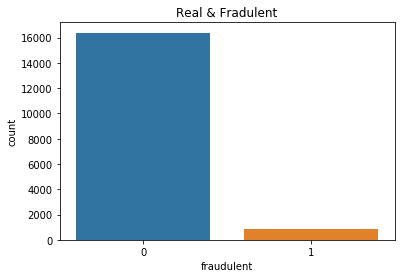

In [5]:
#Fraud and Real visualization
sn.countplot(df.fraudulent).set_title('Real & Fradulent')
df.groupby('fraudulent').count()['title'].reset_index().sort_values(by='title',ascending=False)

In [6]:
#Add title to description column
df['description'] = df['title']+' '+df['description'] 
# Drop the title column
df.drop(['title'], axis = 1, inplace = True)

In [7]:
df2= df.copy()#make a copy

In [9]:
import spacy 
import en_core_web_lg
nlp = en_core_web_lg.load()
from spacy.lang.en import English
parser = English()
import base64
import string
import re
from nltk.corpus import stopwords
stopwords = stopwords.words('english')
from collections import Counter
punctuation = string.punctuation

# Cleaning function which is used for cleaning the text feater. 
def cleanup_text(docs, logging= False):
    texts = []
    for doc in docs:
        doc = nlp (doc, disable=['parser', 'ner'])
        tokens = [tok.lemma_.lower().strip()for tok in doc if tok.lemma_ != '-PRON-']
        tokens = [tok for tok in tokens if tok not in stopwords and tok not in punctuation ]
        tokens = ' '.join(tokens)
        texts.append(tokens)
    return pd.Series(texts)

In [10]:
# finding the most common words in description of fake job pots.

Fraud = [text for text in df2[df2['fraudulent']== 1] ['description']]
Fraud_clean = cleanup_text(Fraud)
Fraud_clean = ' '.join(Fraud_clean).split()
Fraud_counts = Counter(Fraud_clean)
Fraud_common_words= [word[0] for word in Fraud_counts.most_common(20)]
Fraud_common_counts = [word[1] for word in Fraud_counts.most_common(20)]

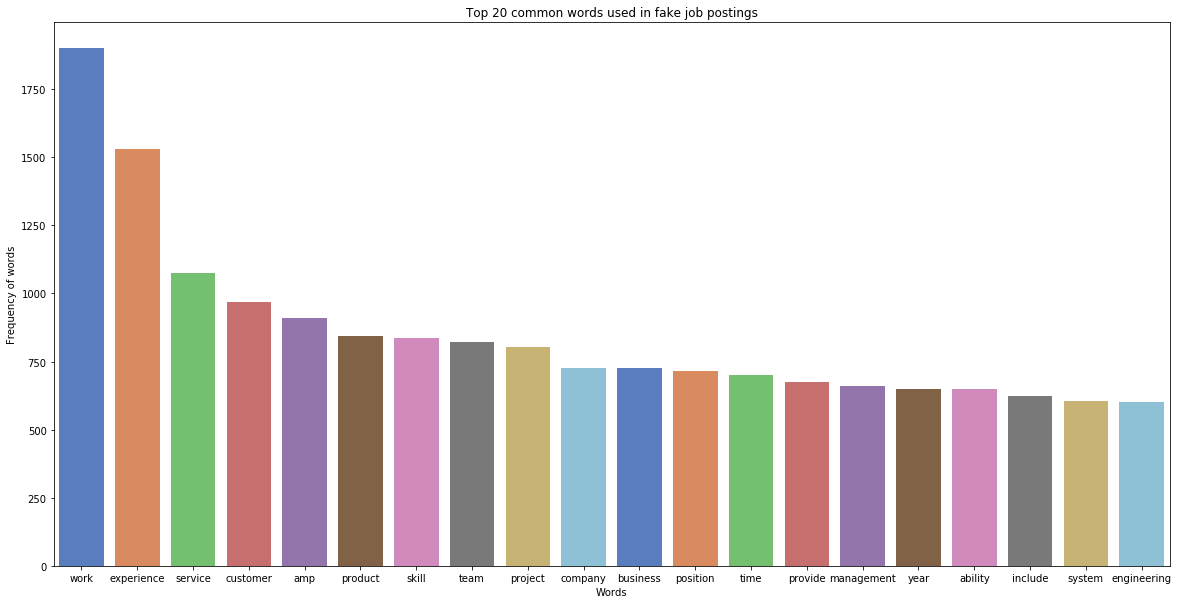

In [11]:

fig= plt.figure(figsize=(20,10))
pal=sn.color_palette("muted")
sn.barplot(x= Fraud_common_words, y=Fraud_common_counts, palette= pal)
plt.title('Top 20 common words used in fake job postings')
plt.ylabel('Frequency of words')
plt.xlabel('Words')
plt.show()

In [12]:
# finding the most common words in description of real job pots.

Real = [text for text in df2[df2['fraudulent']== 0] ['description']]
Real_clean = cleanup_text(Real)
Real_clean = ' '.join(Real_clean).split()
Real_counts = Counter(Real_clean)
Real_common_words= [word[0] for word in Real_counts.most_common(20)]
Real_common_counts = [word[1] for word in Real_counts.most_common(20)]

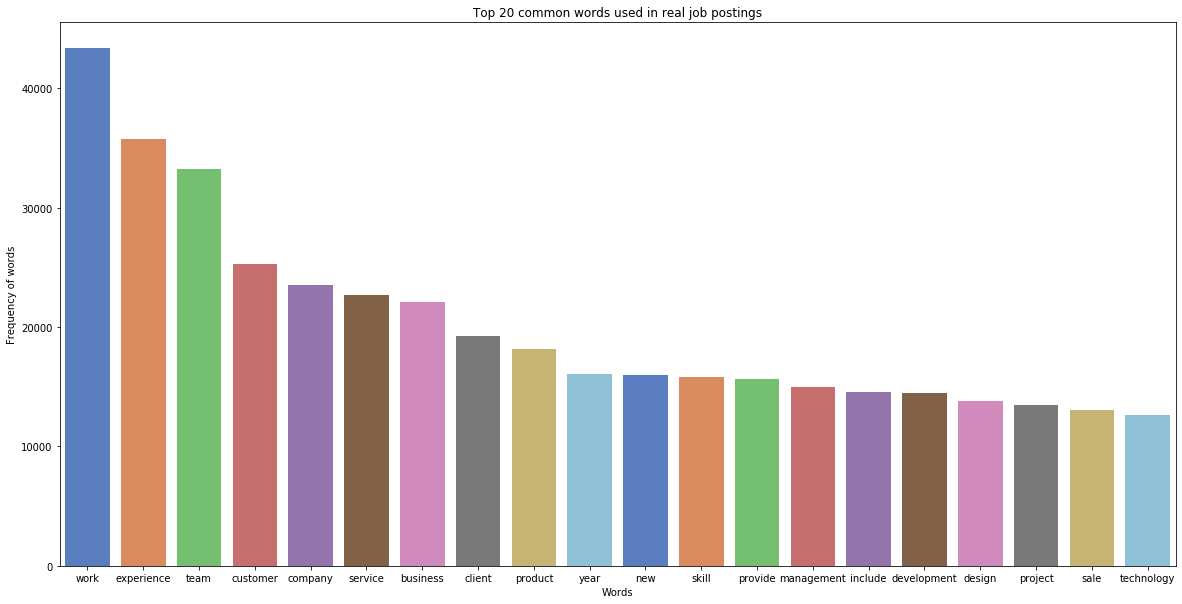

In [13]:
fig= plt.figure(figsize=(20,10))
pal=sn.color_palette("muted") 
sn.barplot(x= Real_common_words, y=Real_common_counts, palette= pal)
plt.title('Top 20 common words used in real job postings')
plt.ylabel('Frequency of words')
plt.xlabel('Words')
plt.show()

In [14]:
# drop the description column
df2.drop(['description'], axis = 1, inplace = True)


In [44]:
df3=df2.copy()# make a copy 

In [63]:
# Split df into train & test
y = df3.fraudulent #target
X = df3.drop(['fraudulent'], axis = 1)#features

# used train_test_split 
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.80, test_size=0.20, random_state=222)
print (X_train.shape)
print (y_train.shape)
print (X_test.shape)
print (y_test.shape)

(13780, 9)
(13780,)
(3445, 9)
(3445,)


In [64]:
# Join our training data back together
X = pd.concat([X_train, y_train], axis=1)
# separate fake and real classes
real = X[X.fraudulent==0]
fake = X[X.fraudulent==1]

In [65]:
from sklearn.utils import resample

# downsample majority
real_downsampled = resample(real,
                                replace = False, # sample without replacement
                                n_samples = len(fake), # same as fake posts
                                random_state = 222) # reproducible results

In [66]:
# combine minority and downsampled majority
downsampled = pd.concat([real_downsampled, fake])
# number of real and fake postings
downsampled.fraudulent.value_counts()

1    667
0    667
Name: fraudulent, dtype: int64

In [67]:
y_train = downsampled.fraudulent
X_train = downsampled.drop('fraudulent', axis=1)

In [68]:
# identify the categorical and numerical columns.
numeric_features = df3.select_dtypes(include=['int64','float64']).drop(['fraudulent'], axis=1).columns
categorical_features = df3.select_dtypes(include=['object']).columns

In [69]:
print("numeric_features:\n",numeric_features)
print("categorical_features:\n:", categorical_features)

numeric_features:
 Index(['telecommuting', 'has_company_logo', 'has_questions'], dtype='object')
categorical_features:
: Index(['employment_type', 'required_experience', 'required_education',
       'industry', 'function', 'country_name'],
      dtype='object')


In [70]:
import category_encoders as ce
# list of encoders is used. 
encoder_list = [ce.binary.BinaryEncoder, #binary encoder
                ce.ordinal.OrdinalEncoder,# ordinal_encoder
                ce.one_hot.OneHotEncoder,# one-hot encoder 
                ]


In [71]:
#LabelEncoder to transform the y labels
le = preprocessing.LabelEncoder()
label_encoder = le.fit(y)
y = label_encoder.transform(y)

In [72]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB 

classifiers = [
    KNeighborsClassifier(5),
    DecisionTreeClassifier(),
    RandomForestClassifier( n_estimators=500),
    LogisticRegression(),
   
  ]

In [78]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve,auc, accuracy_score


<class 'category_encoders.binary.BinaryEncoder'>
KNeighborsClassifier()
model score: 0.818
0.5964013294470736
              precision    recall  f1-score   support

           0       0.99      0.82      0.90      3278
           1       0.18      0.80      0.30       167

    accuracy                           0.82      3445
   macro avg       0.59      0.81      0.60      3445
weighted avg       0.95      0.82      0.87      3445



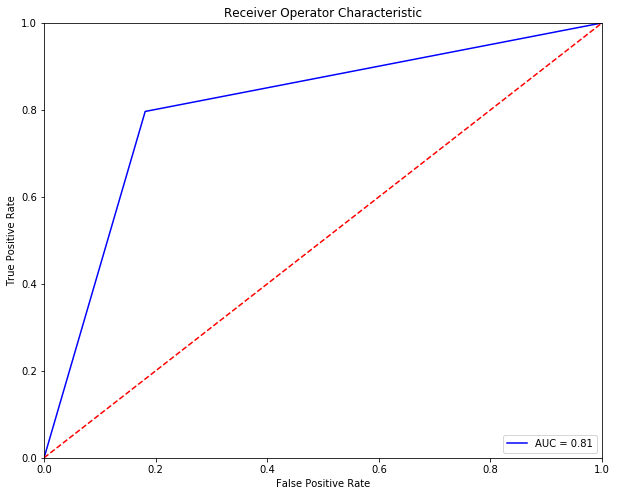

<class 'category_encoders.binary.BinaryEncoder'>
DecisionTreeClassifier()
model score: 0.807
0.5883019818609339
              precision    recall  f1-score   support

           0       0.99      0.81      0.89      3278
           1       0.18      0.81      0.29       167

    accuracy                           0.81      3445
   macro avg       0.58      0.81      0.59      3445
weighted avg       0.95      0.81      0.86      3445



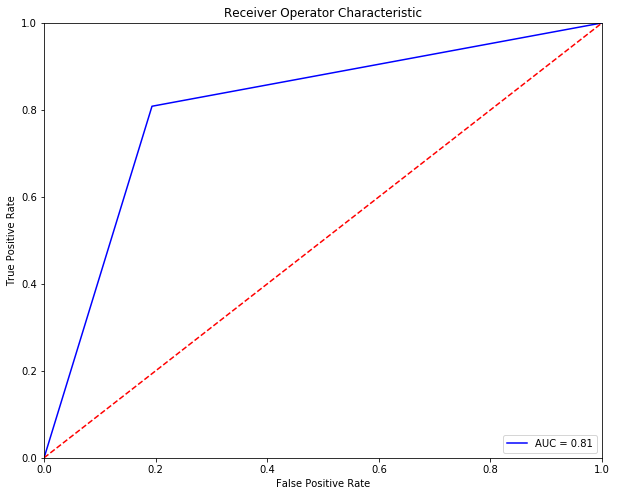

<class 'category_encoders.binary.BinaryEncoder'>
RandomForestClassifier(n_estimators=500)
model score: 0.842
0.6301747029470793
              precision    recall  f1-score   support

           0       0.99      0.84      0.91      3278
           1       0.22      0.88      0.35       167

    accuracy                           0.84      3445
   macro avg       0.61      0.86      0.63      3445
weighted avg       0.96      0.84      0.88      3445



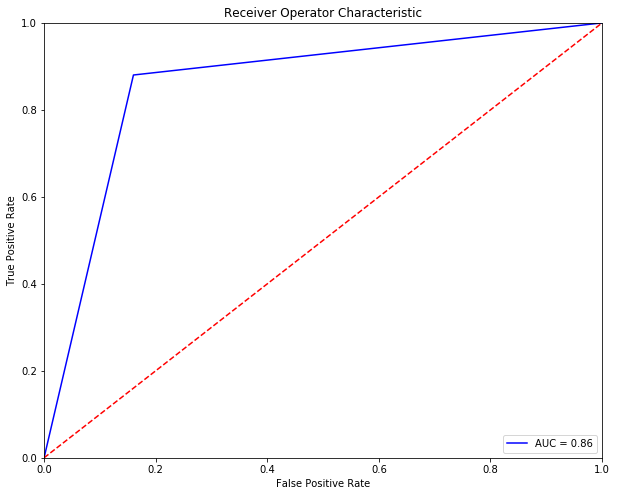

<class 'category_encoders.binary.BinaryEncoder'>
LogisticRegression()
model score: 0.743
0.5399272193740043
              precision    recall  f1-score   support

           0       0.99      0.74      0.85      3278
           1       0.14      0.81      0.23       167

    accuracy                           0.74      3445
   macro avg       0.56      0.77      0.54      3445
weighted avg       0.95      0.74      0.82      3445



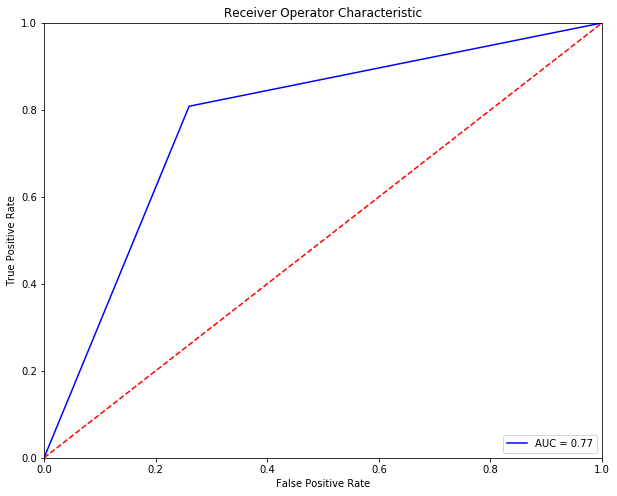

<class 'category_encoders.ordinal.OrdinalEncoder'>
KNeighborsClassifier()
model score: 0.700
0.5066787442428925
              precision    recall  f1-score   support

           0       0.98      0.70      0.82      3278
           1       0.11      0.76      0.20       167

    accuracy                           0.70      3445
   macro avg       0.55      0.73      0.51      3445
weighted avg       0.94      0.70      0.79      3445



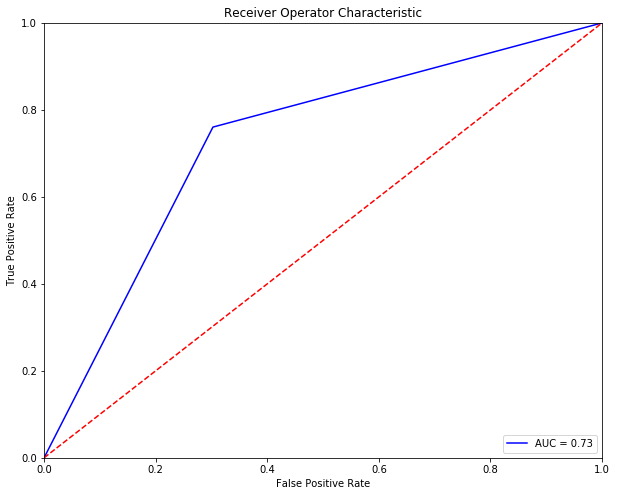

<class 'category_encoders.ordinal.OrdinalEncoder'>
DecisionTreeClassifier()
model score: 0.785
0.5690973992860785
              precision    recall  f1-score   support

           0       0.99      0.78      0.87      3278
           1       0.16      0.80      0.26       167

    accuracy                           0.78      3445
   macro avg       0.57      0.79      0.57      3445
weighted avg       0.95      0.78      0.84      3445



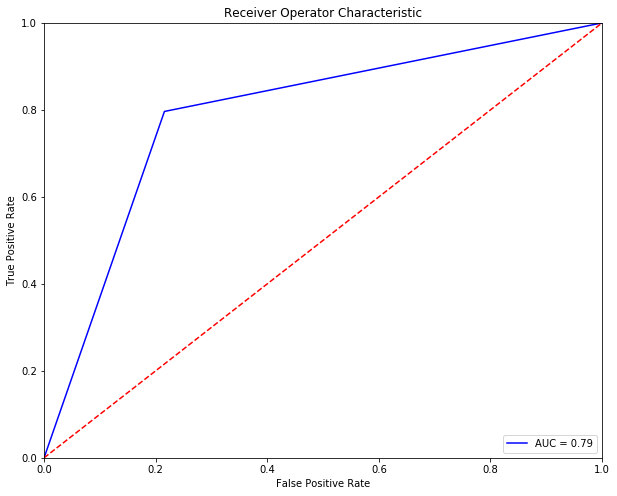

<class 'category_encoders.ordinal.OrdinalEncoder'>
RandomForestClassifier(n_estimators=500)
model score: 0.826
0.6109569036199934
              precision    recall  f1-score   support

           0       0.99      0.82      0.90      3278
           1       0.20      0.85      0.32       167

    accuracy                           0.83      3445
   macro avg       0.59      0.84      0.61      3445
weighted avg       0.95      0.83      0.87      3445



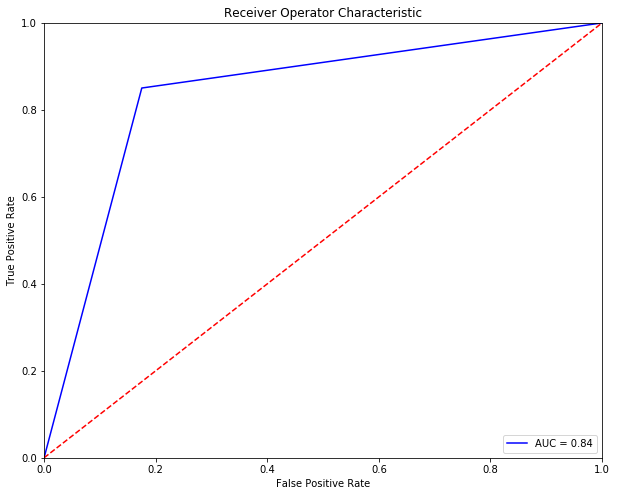

<class 'category_encoders.ordinal.OrdinalEncoder'>
LogisticRegression()
model score: 0.779
0.5473179483761614
              precision    recall  f1-score   support

           0       0.98      0.78      0.87      3278
           1       0.13      0.66      0.22       167

    accuracy                           0.78      3445
   macro avg       0.56      0.72      0.55      3445
weighted avg       0.94      0.78      0.84      3445



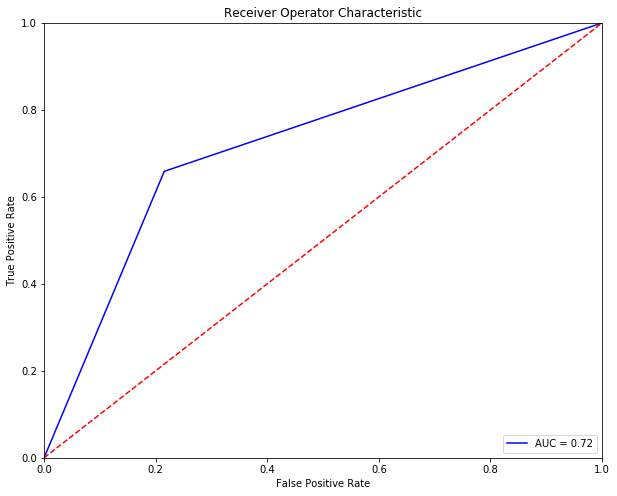

<class 'category_encoders.one_hot.OneHotEncoder'>
KNeighborsClassifier()
model score: 0.884
0.6689523404192096
              precision    recall  f1-score   support

           0       0.99      0.89      0.94      3278
           1       0.27      0.81      0.40       167

    accuracy                           0.88      3445
   macro avg       0.63      0.85      0.67      3445
weighted avg       0.95      0.88      0.91      3445



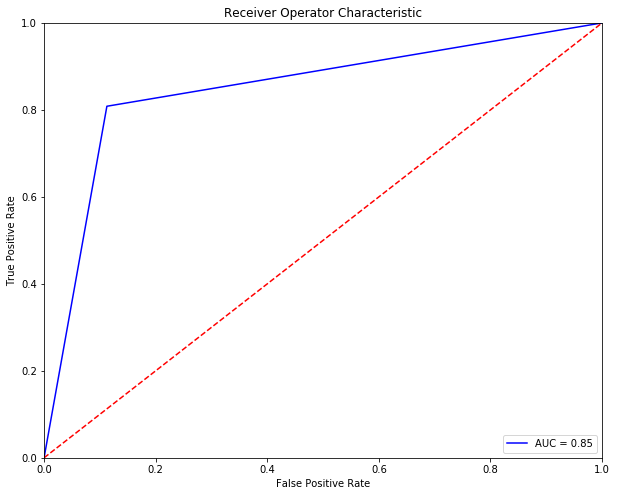

<class 'category_encoders.one_hot.OneHotEncoder'>
DecisionTreeClassifier()
model score: 0.841
0.6225992816946286
              precision    recall  f1-score   support

           0       0.99      0.84      0.91      3278
           1       0.21      0.83      0.34       167

    accuracy                           0.84      3445
   macro avg       0.60      0.83      0.62      3445
weighted avg       0.95      0.84      0.88      3445



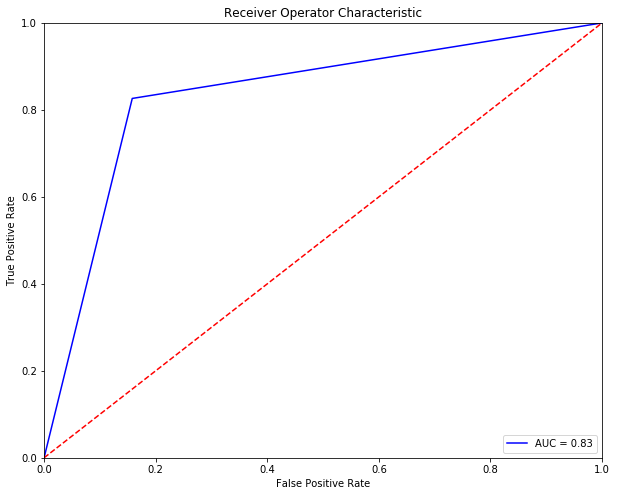

<class 'category_encoders.one_hot.OneHotEncoder'>
RandomForestClassifier(n_estimators=500)
model score: 0.868
0.6615931821003147
              precision    recall  f1-score   support

           0       0.99      0.87      0.93      3278
           1       0.26      0.90      0.40       167

    accuracy                           0.87      3445
   macro avg       0.62      0.88      0.66      3445
weighted avg       0.96      0.87      0.90      3445



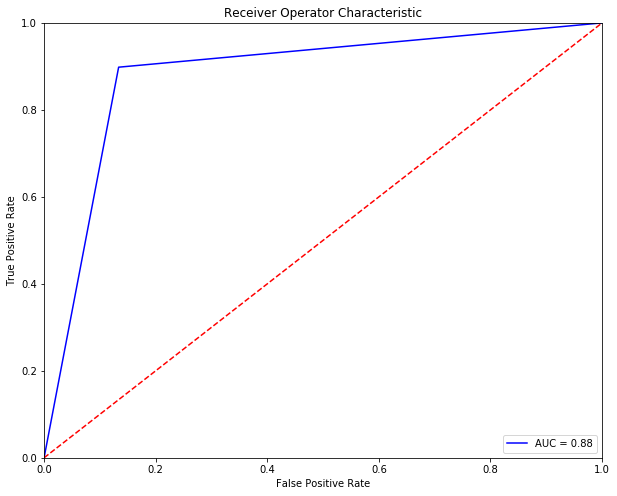

<class 'category_encoders.one_hot.OneHotEncoder'>
LogisticRegression()
model score: 0.785
0.578078274380975
              precision    recall  f1-score   support

           0       0.99      0.78      0.87      3278
           1       0.17      0.87      0.28       167

    accuracy                           0.78      3445
   macro avg       0.58      0.83      0.58      3445
weighted avg       0.95      0.78      0.84      3445



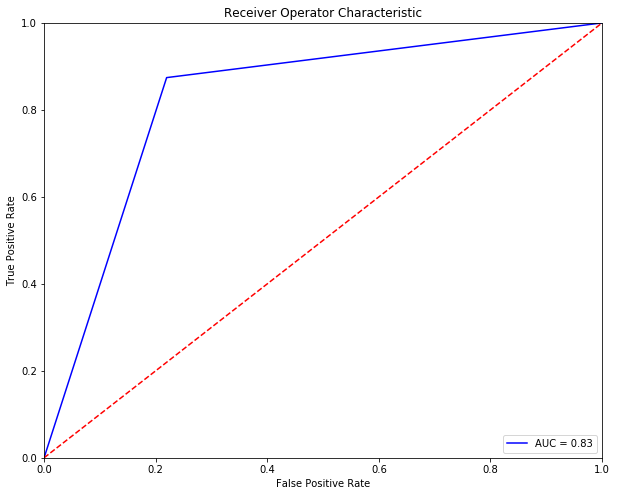

In [73]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

for encoder in encoder_list:
    # pipeline for numeric data 
    numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])
    # pipeline for categorical data 
    categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant')),
    ('woe', encoder())])
    
    preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])
    for classifier in classifiers:
        pipe = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', classifier)])
    
        model = pipe.fit(X_train, y_train)
   
        y_pred = model.predict(X_test)
        print(encoder)
        print(classifier)
        print("model score: %.3f" % pipe.score(X_test, y_test))
        print(f1_score(y_test, y_pred, average='macro'))
        print(classification_report(y_test, y_pred))
        fpr, tpr, threshold = roc_curve(y_test, y_pred)
        roc_auc = auc(fpr, tpr)
        plt.figure(figsize=(10,8))
        plt.title('Receiver Operator Characteristic')
        plt.plot(fpr, tpr, 'b', label = 'AUC = {}'.format(round(roc_auc, 2)))
        plt.legend(loc = 'lower right')
        plt.plot([0,1], [0,1], 'r--')
        plt.xlim([0,1])
        plt.ylim([0,1])
        plt.ylabel('True Positive Rate')
        plt.xlabel('False Positive Rate')
        plt.show()

    

In [74]:
from sklearn.utils import resample

# oversample majority
fake_upsampled = resample(fake,
                                replace = True, # sample with replacement
                                n_samples = len(real), # same as fake posts
                                random_state = 222) # reproducible results

In [75]:
# combine Majority and upsampled minority
upsampled = pd.concat([fake_upsampled, real])
# number of real and fake postings
upsampled.fraudulent.value_counts()

1    13113
0    13113
Name: fraudulent, dtype: int64

In [76]:
y_train2 = upsampled.fraudulent
X_train2 = upsampled.drop('fraudulent', axis=1)

<class 'category_encoders.binary.BinaryEncoder'>
KNeighborsClassifier()
model score: 0.869
0.6609714684609975


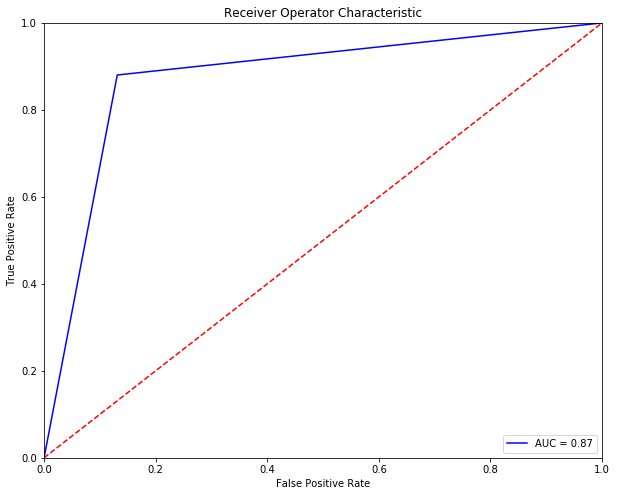

<class 'category_encoders.binary.BinaryEncoder'>
DecisionTreeClassifier()
model score: 0.951
0.779565642878651


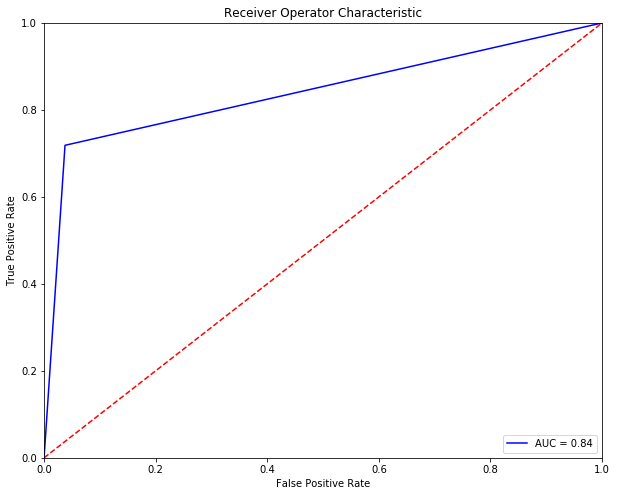

<class 'category_encoders.binary.BinaryEncoder'>
RandomForestClassifier(n_estimators=500)
model score: 0.964
0.8153812169716743


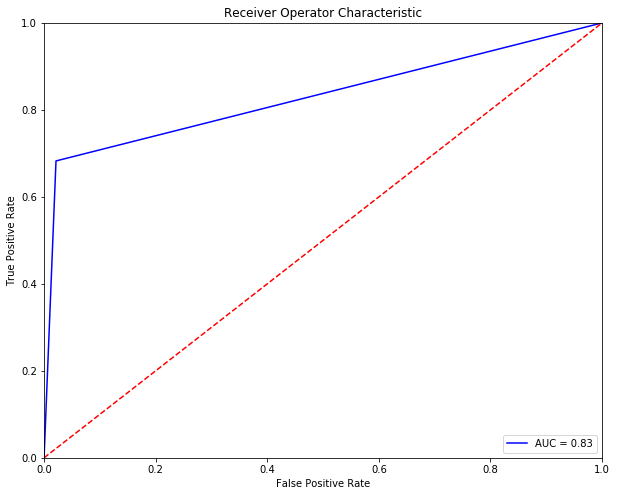

<class 'category_encoders.binary.BinaryEncoder'>
LogisticRegression()
model score: 0.793
0.5733572730410278


C:\Users\soley\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


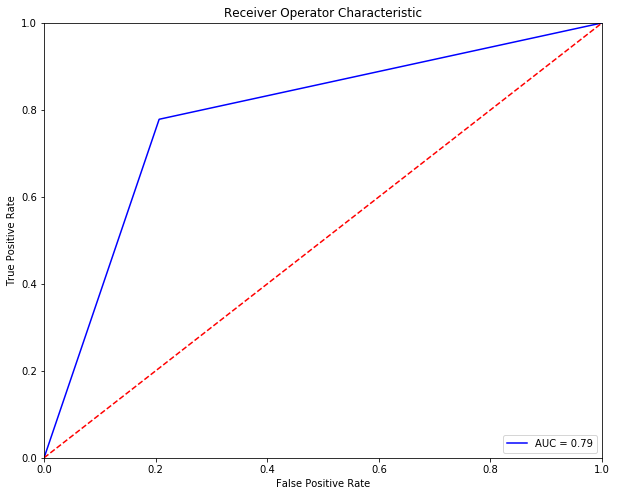

<class 'category_encoders.ordinal.OrdinalEncoder'>
KNeighborsClassifier()
model score: 0.931
0.7341257474675735


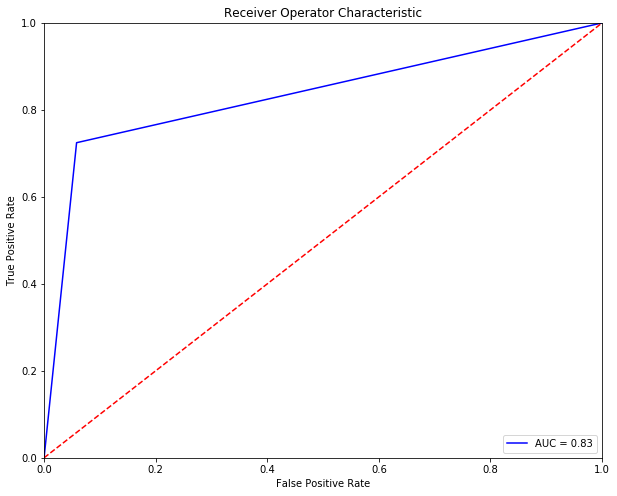

<class 'category_encoders.ordinal.OrdinalEncoder'>
DecisionTreeClassifier()
model score: 0.947
0.7519055656408284


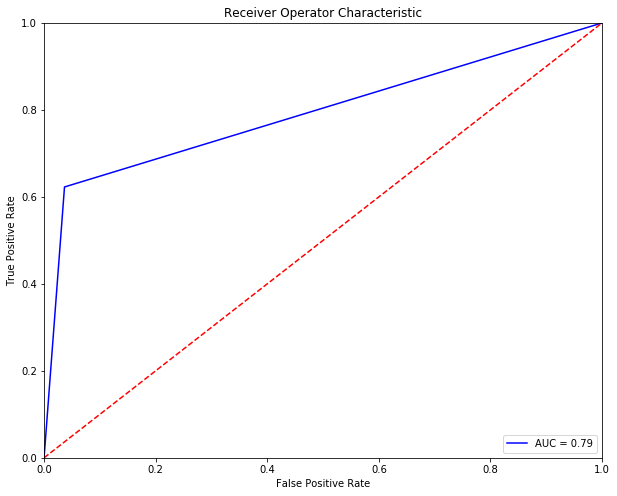

<class 'category_encoders.ordinal.OrdinalEncoder'>
RandomForestClassifier(n_estimators=500)
model score: 0.961
0.8057867683634554


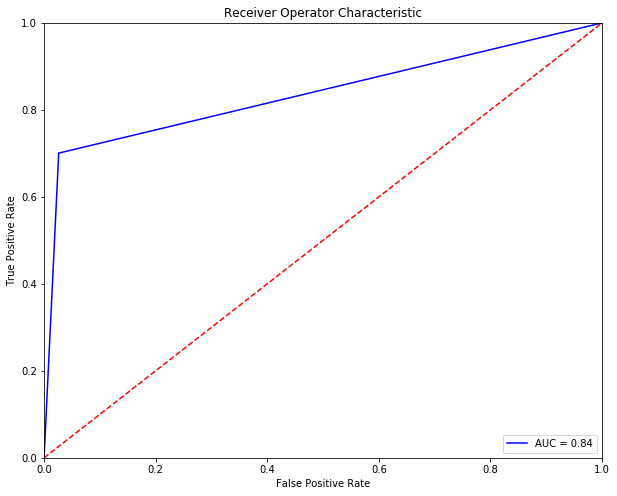

<class 'category_encoders.ordinal.OrdinalEncoder'>
LogisticRegression()
model score: 0.797
0.5605758139711676


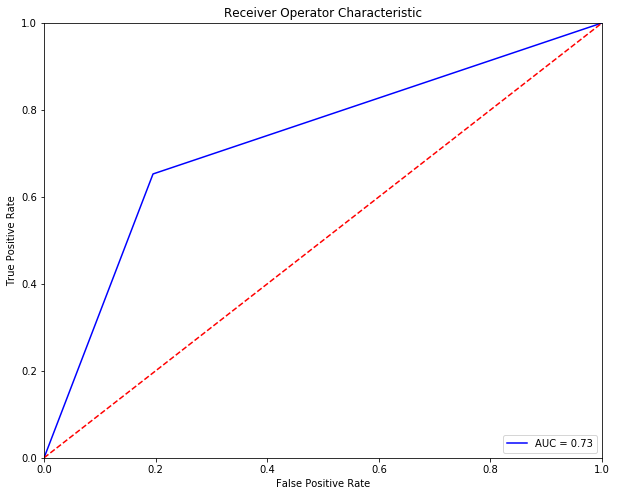

<class 'category_encoders.one_hot.OneHotEncoder'>
KNeighborsClassifier()
model score: 0.808
0.6047317453761072


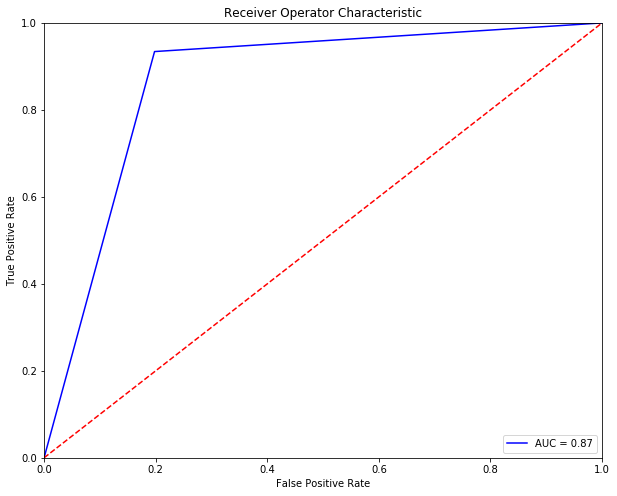

<class 'category_encoders.one_hot.OneHotEncoder'>
DecisionTreeClassifier()
model score: 0.952
0.7839491916425478


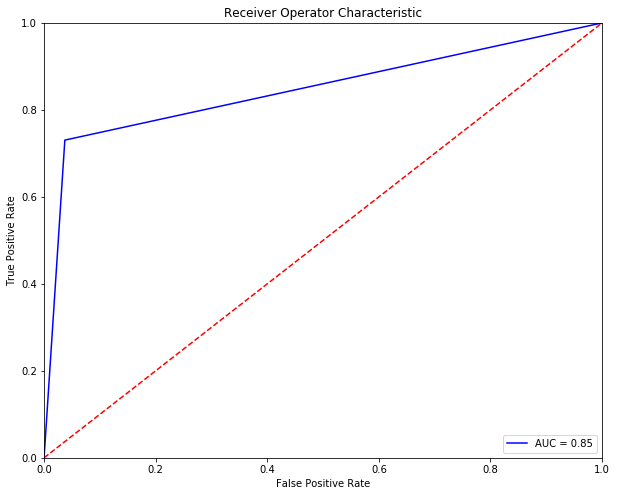

<class 'category_encoders.one_hot.OneHotEncoder'>
RandomForestClassifier(n_estimators=500)
model score: 0.966
0.8224071647007427


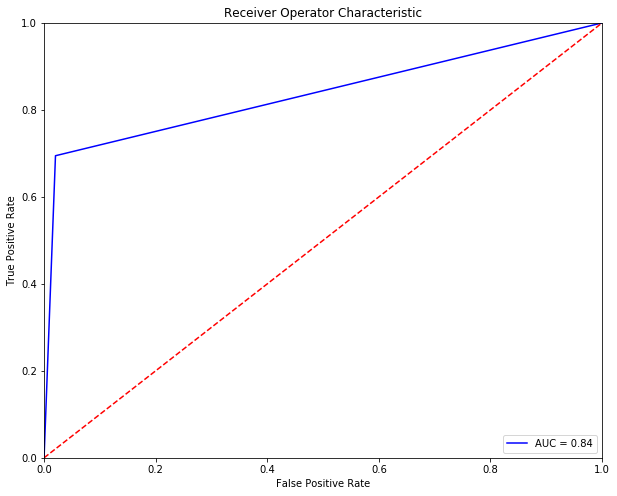

C:\Users\soley\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


<class 'category_encoders.one_hot.OneHotEncoder'>
LogisticRegression()
model score: 0.830
0.6130240393315115


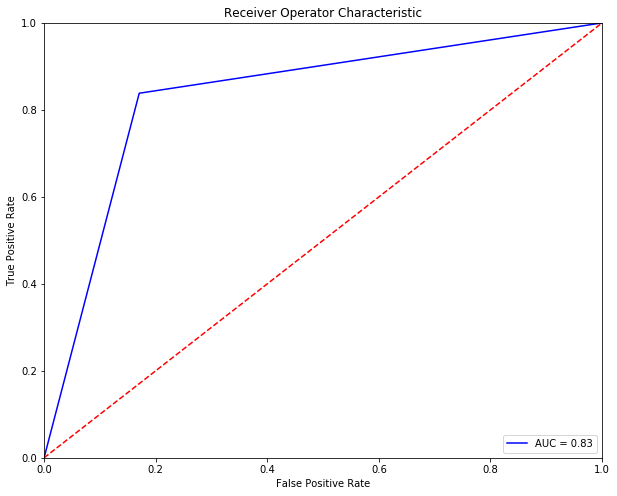

In [77]:
for encoder in encoder_list:
    # pipeline for numeric data 
    numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])
    # pipeline for categorical data 
    categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant')),
    ('woe', encoder())])
    
    preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])
    for classifier in classifiers:
        pipe = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', classifier)])
    
        model = pipe.fit(X_train2, y_train2)
   
        y_pred = model.predict(X_test)
        print(encoder)
        print(classifier)
        print("model score: %.3f" % pipe.score(X_test, y_test))
        print(f1_score(y_test, y_pred, average='macro'))
        #print(classification_report(y_test, y_pred))
        fpr, tpr, threshold = roc_curve(y_test, y_pred)
        roc_auc = auc(fpr, tpr)
        plt.figure(figsize=(10,8))
        plt.title('Receiver Operator Characteristic')
        plt.plot(fpr, tpr, 'b', label = 'AUC = {}'.format(round(roc_auc, 2)))
        plt.legend(loc = 'lower right')
        plt.plot([0,1], [0,1], 'r--')
        plt.xlim([0,1])
        plt.ylim([0,1])
        plt.ylabel('True Positive Rate')
        plt.xlabel('False Positive Rate')
        plt.show()

    